## Compare louvain with subreddit communities
In this notebook, the goal is to compare the communities found with Louvain method and the community of each subreddit.

### Subreddit communities
First, we build a list of communities by subreddit. A person is assigned to the subreddit's community where he post the most frequently.

In [432]:
import pandas as pd
from collections import Counter
import ast

# Load csv
df_subs = pd.read_csv('../data/csv/subs.csv')
df_subs["subreddit"] = df_subs["subreddit"].apply(lambda x: ast.literal_eval(x))

# Keep with the most frequent subreddit for each person
df_subs["most_freq_sub"] = df_subs["subreddit"].apply(lambda x: Counter(x).most_common(1)[0][0])

# Group by subreddit to build the list of communities
df_subs_agg = df_subs.groupby("most_freq_sub")["Id"].agg(lambda x: set(x))

# List of communities
com_subreddit = df_subs_agg.values.tolist()

# Dict of communities with the subreddit's name as key
com_subreddit_dict = df_subs_agg.to_dict()

With these communities, we can plot the size each one to compare them.

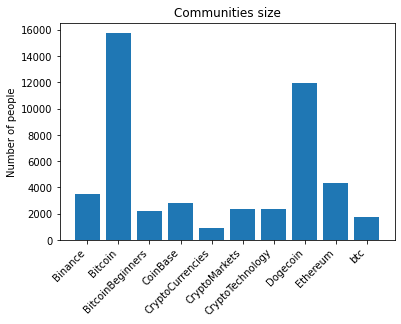

In [433]:
from matplotlib import pyplot as plt

# Dict with length of each community
size_com_subreddit = {k: len(v) for k,v in com_subreddit_dict.items()}

# Plot
names = list(size_com_subreddit.keys())
values = list(size_com_subreddit.values())
plt.bar(range(len(size_com_subreddit)), values, tick_label=names)
plt.title("Communities size")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of people")
plt.savefig('../data/images/communities_size.pdf')
plt.show()

We see that there are 2 big communities, Bitcoin and Dogecoin. The other communities are quite similar but have less than half the population of the two largest.

As we said above, we choose to associate each person where they interact the most. It can be interesting to see the percentage of people who post in several subreddits and those in only one.

In [434]:
# Compute the percentage of interacting for each subreddit
df_subs["percent_by_sub"] = df_subs["subreddit"].apply(lambda list: {el: round(list.count(el) / len(list), 2) for el in list})

# Take max percentage
df_subs["max_percent"] = df_subs["percent_by_sub"].apply(lambda d: d[max(d, key=d.get)])

# Filter people who posts in several subreddit
df_subs_multiple = df_subs.loc[df_subs['max_percent'] < 1]

print(f"Total number of people: {len(df_subs)}")
print(f"Number of people who have interacted in several subreddits: {len(df_subs_multiple)} ({round(len(df_subs_multiple) / len(df_subs) * 100, 2)}%)")
print(f"Descriptive statistics of the maximum percentage of interaction in a subreddit for the {round(len(df_subs_multiple) / len(df_subs) * 100, 2)}% users:")
print(df_subs_multiple['max_percent'].describe())

Total number of people: 47919
Number of people who have interacted in several subreddits: 4682 (9.77%)
Descriptive statistics of the maximum percentage of interaction in a subreddit for the 9.77% users:
count    4682.000000
mean        0.630459
std         0.153883
min         0.180000
25%         0.500000
50%         0.650000
75%         0.750000
max         0.990000
Name: max_percent, dtype: float64


Most of users (90%) only post in one subreddit. For the remaining ~10%, if we look at the percentage of interaction per user for each subreddit and take the maximum, on average we get 63%. This means that most of the people who post on several subreddit still have a main subreddit on which they interact the most. 

With this result, building communities by associating each person where they interacts the most seems to be a good solution.

If we take the 10% of users who post on several subreddit, it can also be good to see the percentage of interaction for each subreddit.

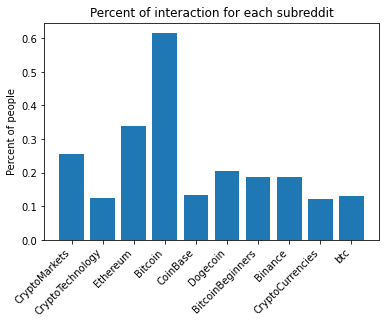

In [435]:
# Create dataframe with percentage of post for all subreddit for each user
df_subs_percent = pd.DataFrame(df_subs_multiple["percent_by_sub"].to_list()).fillna(0)

# Transform to a dict 
subs_percent_dict = {col: len(df_subs_percent.loc[df_subs_percent[col] > 0]) / len(df_subs_percent) for col in df_subs_percent.columns}

# Plot
names = list(subs_percent_dict.keys())
values = list(subs_percent_dict.values())
plt.bar(range(len(subs_percent_dict)), values, tick_label=names)
plt.title("Percent of interaction for each subreddit")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Percent of people")
plt.savefig('../data/images/communities_percent.pdf')
plt.show()

For the users that post on several subreddit, we can observe that 60% of them have interacted in "Bitcoin" subreddit. This shows once again that it's an important one. For the Dogecoin, it's interesting to see it's only 20% even though it is a large community. Dogecoin community seems to stay only in their subreddit. 

### Louvain communities
We can now create another list of communities by running Louvain method on the graph "edges_deep_link_no_merge".

In [436]:
import networkx as nx
import networkx.algorithms.community as nx_comm

# Load graph
df_edges = pd.read_csv('../data/csv/edges_deep_link_no_merge.csv')
G = nx.from_pandas_edgelist(df_edges)

# Compute partitions with louvain
com_louvain = nx_comm.louvain_communities(G, seed=123)

Than we can compare the number of Louvain communities and the number of subreddit.

In [437]:
print(f"Number of Louvain communities: {len(com_louvain)}")
print(f"Number of subreddit: {len(com_subreddit)}")

Number of Louvain communities: 258
Number of subreddit: 10


Louvain method extract a lot of communities compare to the number of subreddit. A subreddit can therefore have several inner communities. However are all these communities releveant? Evaluation is a bit difficult since there is no real ground truth. Subreddit communities is not realy a ground truth. We could imagine that some louvain communities interact in several subreddit.

We can start by looking at length of each Louvain communities.

In [438]:
# Print length of all communities
print(f"Length of each Louvain communities:\n{[len(c) for c in com_louvain]}")

Length of each Louvain communities:
[329, 2, 3014, 2, 2893, 2, 2, 5, 2, 2, 2, 2, 2, 5934, 2, 3, 2, 3, 7, 2, 2, 2, 383, 11, 152, 2, 2, 2, 2, 3, 2, 2, 4, 5, 2, 2, 3, 2, 2, 4, 2, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 4, 2, 2, 10, 2, 2, 5, 2, 2, 2, 5, 2, 401, 10214, 2, 2, 2, 4, 2, 3, 2, 2, 6, 2, 2, 3, 3, 180, 687, 1083, 24, 2243, 2, 38, 2, 8, 2, 3, 13, 15, 2, 2, 2, 2, 2, 276, 2, 2, 532, 2, 203, 2, 2, 2, 3, 3, 508, 5, 5, 2, 2, 848, 189, 1211, 2, 3, 8, 2, 2, 3, 6, 2, 719, 8, 2, 2, 2, 9, 6, 24, 2, 6, 3, 2, 2, 2, 2392, 2, 1073, 4, 2, 2, 3, 4, 2, 2, 2, 2, 2, 2, 5, 3, 3, 7, 2, 2, 24, 1947, 4, 2, 3, 2, 2, 3, 2, 3, 2, 7940, 4, 2, 2, 4, 2, 7, 2, 2, 2, 2, 2, 2, 2, 6, 3, 2, 2, 2, 2, 3, 5, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 6, 21, 2, 2, 2, 17, 39, 2, 2, 2, 2, 2, 6, 2, 2, 3, 2, 3, 3, 86, 139, 3, 2, 25, 2, 168, 2, 2, 2, 2]


There is a lot of communities of 2 people. This may lead us to believe that there are many users who have interacted with only one person. We can verify that be looking at the number of edges for each node.

In [439]:
# Compute numbers of edges per nodes
nbr_edges_per_nodes = [len(G.edges(n)) for n in G]
nbr_1_egde = len([1 for i in nbr_edges_per_nodes if i < 2])
nbr_2_egde = len([1 for i in nbr_edges_per_nodes if i < 3])
print(f"Number of nodes in graph: {len(G)}")
print(f"Number of nodes with only 1 egde: {nbr_1_egde} ({round(nbr_1_egde / len(G) * 100, 2)}%)")
print(f"Number of nodes with less than 8 egdes: {nbr_2_egde} ({round(nbr_2_egde / len(G) * 100, 2)}%)")

Number of nodes in graph: 46594
Number of nodes with only 1 egde: 14608 (31.35%)
Number of nodes with less than 8 egdes: 22907 (49.16%)


We can see that ~30% of the people have only one edge and that ~50% have less than 3 edges. So, most of the users do not necessarily post a lot which explains the number of small communities found by Louvain method.

We can now filter the Louvain community by taking only the communities that have more than 5 people to reduce the number of communities.

In [440]:
small_com_louvain = [c for c in com_louvain if len(c) > 5]

print(f"Number of Louvain communities: {len(com_louvain)}")
print(f"Number of Louvain communities with more than 5 users: {len(small_com_louvain)}")

Number of Louvain communities: 258
Number of Louvain communities with more than 5 users: 53


### Compare two list of communities

The two lists of communities are not extracted from the same file. So there may be a difference between the people in the two datasets. We can therefore compare them:

In [441]:
persons_louvain = set().union(*small_com_louvain)
persons_subreddit = set().union(*com_subreddit)

print(f"Total number of person in list of communities:\n • Louvain - {len(persons_louvain)}\n • Subreddit - {len(persons_subreddit)}")
print(f"Intersection between the two set of people: {len(persons_louvain.intersection(persons_subreddit))}")

Total number of person in list of communities:
 • Louvain - 46101
 • Subreddit - 47919
Intersection between the two set of people: 46101


As we said before, a subreddit can have several communities but it can be interesting to see if communities are formed by people from different subreddits. For this, we loop over the Louvain communities and compute the percentage of people coming from each subreddit. It gives a matrix where rows are Louvain communities and columns are the percentage of people from each subreddit.

As all the people in the Louvain dataset are included in the subreddit dataset, the sum of element in each line is a percentage of 1.0.

In [442]:
# Get set intersection between louvain and subreddit communities
intersections = []

for cl in small_com_louvain:
   intersections.append([len(cl.intersection(cs)) / len(cl) for cs in com_subreddit])

# Print matrix
print([k for k in com_subreddit_dict.keys()])

for inter in intersections[:4]:
   print(['%.2f' % v for v in inter])

print("...")

for inter in intersections[-4:]:
   print(['%.2f' % v for v in inter])

['Binance', 'Bitcoin', 'BitcoinBeginners', 'CoinBase', 'CryptoCurrencies', 'CryptoMarkets', 'CryptoTechnology', 'Dogecoin', 'Ethereum', 'btc']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.99', '0.00', '0.00']
['0.02', '0.04', '0.03', '0.85', '0.01', '0.01', '0.01', '0.01', '0.02', '0.00']
['0.07', '0.09', '0.01', '0.01', '0.20', '0.50', '0.02', '0.01', '0.09', '0.00']
['0.01', '0.05', '0.01', '0.00', '0.02', '0.07', '0.33', '0.01', '0.50', '0.00']
...
['1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.01', '0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.97', '0.01', '0.00']
['1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.91', '0.01', '0.00', '0.01', '0.06', '0.01', '0.00', '0.01', '0.00']


To have a better understanding of the result, we can plot a histogram of the number of different subreddits that people in a Louvain community belong to.

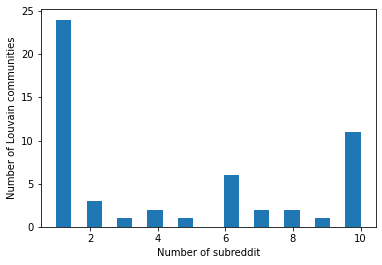

In [443]:
# Compute repartition for each Louvain community
repartition = [sum(1 if v else 0 for v in inter) for inter in intersections]

# Plot
plt.hist(repartition, bins=20)
plt.ylabel("Number of Louvain communities")
plt.xlabel("Number of subreddit")
plt.savefig('../data/images/inner_communities_repartition.pdf')
plt.show()

We can see that the Louvain communities are not all restricted to one subreddit. Some are interacting in several subreddit but this is not the case for the majority.

Now, we can also look at how the number of people in a community change the number of different subreddit.

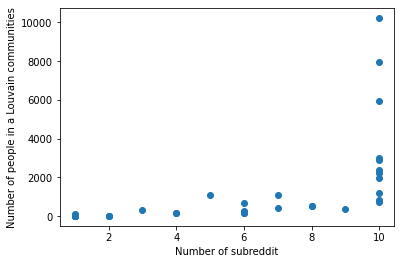

In [444]:
x = repartition
y = [len(c) for c in small_com_louvain]

plt.scatter(x, y)
plt.ylabel("Number of people in a Louvain communities")
plt.xlabel("Number of subreddit")
plt.savefig('../data/images/communities_repartition_by_size.pdf')
plt.show()

As we might expect, very large communities (1500+ persons) affect all subreddits while smaller ones are present on less subreddit.

Finally it can be intersting to see how many communities are present in each subreddit.

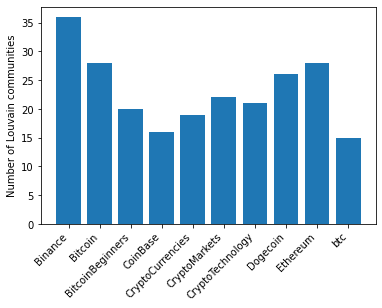

In [445]:
# Compute number of communities per subreddit
nrb_com_per_sub = [0] * len(com_subreddit)
for inter in intersections:
   for i, el in enumerate(inter):
      nrb_com_per_sub[i] += 1 if el > 0 else 0

# Print 
names = list(com_subreddit_dict.keys())
plt.bar(range(len(subs_percent_dict)), nrb_com_per_sub, tick_label=names)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Louvain communities")
plt.savefig('../data/images/nbr_communities_per_sub.pdf')
plt.show()

The result of each subreddit is quite similar. Even if a subreddit is large, the number of communities that interact in it remains close to the others.

### Summary

Louvain method is a technique that find communities from large networks. In our case, we see that there is 260 communities found with Louvain method in only 10 subreddit. However, most of them are only group of 2 nodes. Indeed, 30% of the users have interacted with only one other user.

Each subreddit has inner communities that interact with each other but all these communities are not restricted to one subreddit. Some are interacting in several subreddit. The larger a community is, the more it seems to interact on several subreddits